# Delta Hedging The Short Straddle
In this notebook, delta hedging is implemented on short straddle to prevent losses during black swan events like dot com crisis, 2008 financial crisis and also to increase the profits in general.

## Short Straddle
This is an Options Strategy where one sells a call and put options at the same strike price. This strategy involves a lot of risk as it can result in unlimited losses.

![](Short-Straddle.jpg)

The strategy is implemented on SPY stock. CBOE volatility index (^VIX) is used for implied volatility. Stock prices from the beginning till 31st December 2019 are downloaded from finance.yahoo.com

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

In [2]:
spy = pd.read_csv('SPY.csv',index_col='Date',parse_dates=True)
vix = pd.read_csv('^VIX.csv',index_col='Date',parse_dates=True)

In [3]:
#Selecting the required columns for the analysis
df = pd.merge(spy[['Adj Close']],vix[['Close']],on='Date',how='left')

In [4]:
#Renaming the columns suitably
df.rename(columns={'Adj Close':'spy','Close':'vix'},inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


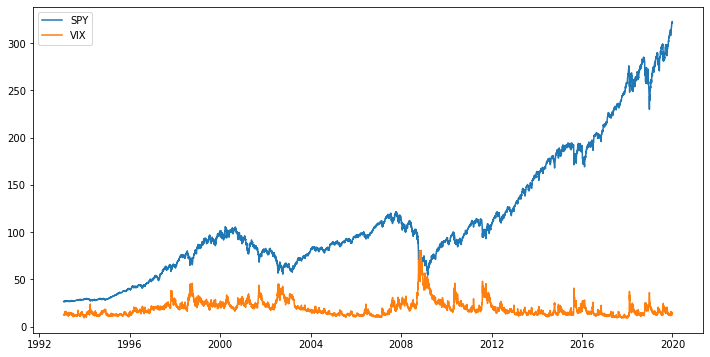

In [5]:
#Visualize the stock price and implied volatility
plt.figure(figsize=(12,6))
plt.plot(df['spy'],label='SPY')
plt.plot(df['vix'],label='VIX')
plt.legend()

## Option Pricing
Options are priced using Black-Scholes Model. For simplifying the analysis, it is assumed that options are exercised only when the time value of the options are low. In other words, European options are used in the analysis. To know more about the Black-Scholes Model, refer Wikipedia.

In [6]:
def option_price(St,sigma,r,T,K):
    d1 = (np.log(St/K) + (r+sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    Nd1 = norm.cdf(d1)
    Nd2 = norm.cdf(d2)
    C = St*Nd1 - K*np.exp(-r*T)*Nd2
    P = K*np.exp(-r*T)*(1-Nd2) - St*(1-Nd1)
    return C,P,Nd1

At the money options are used in the analysis. Hence Strike Price is taken as the smallest integer value greater than SPY closing price. Expiration date is taken as 28 financial days after the option is written. Risk free interest rate is taken as 2% for the entire time period (this value gives option prices close to the historical option prices).

## Delta
Delta of an option is defined as rate of change of option price with the stock price. 
For a European call option delta is given by N(d1) and for a European put option it is given by N(-d1).
Hence delta of a short straddle is N(d1)+N(-d1) or 2*N(d1) - 1.

In [7]:
df.reset_index([0],inplace=True)
for i in range(len(df['spy'])):
    j = i - i%28  ##j is used to calculate the strike price of the options written. 
    df.at[i,'Call'] = option_price(df.at[i,'spy'],df.at[i,'vix']/100,0.02,1/12,int(df.at[i,'spy'])+1)[0]
    df.at[i,'Put'] = option_price(df.at[i,'spy'],df.at[i,'vix']/100,0.02,1/12,int(df.at[i,'spy'])+1)[1]
    df.at[i,'Delta'] = (2*option_price(df.at[i,'spy'],df.at[i,'vix']/100,0.02,1/12,int(df.at[j,'spy'])+1)[2]-1)*100

## Cash Flow from Short Straddle
Cash Flow is equal to premium collected from call and put options minus the difference between Strike price and Stock price on the expiration date. Every time 100 options of each type are sold at the same strike price.

In [8]:
#Calculating cumulative cash flow from short straddle
df['cflow'] = 0.0
for i in np.arange(28,len(df['spy']),28):
    K = int(df.at[i-28,'spy'])+1
    St = df.at[i,'spy']
    C = df.at[i,'Call']
    P = df.at[i,'Put']
    df.at[i,'cflow'] = (C + P - abs(St-K))*100.00
df['cum_cflow'] = df['cflow'].cumsum()

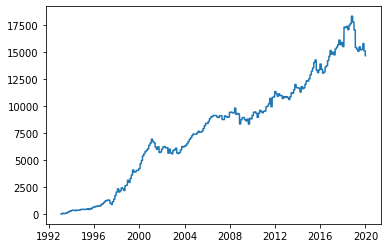

In [10]:
plt.plot_date(df['Date'],df['cum_cflow'],'-')

## Finding the pattern in delta values when the loss is large

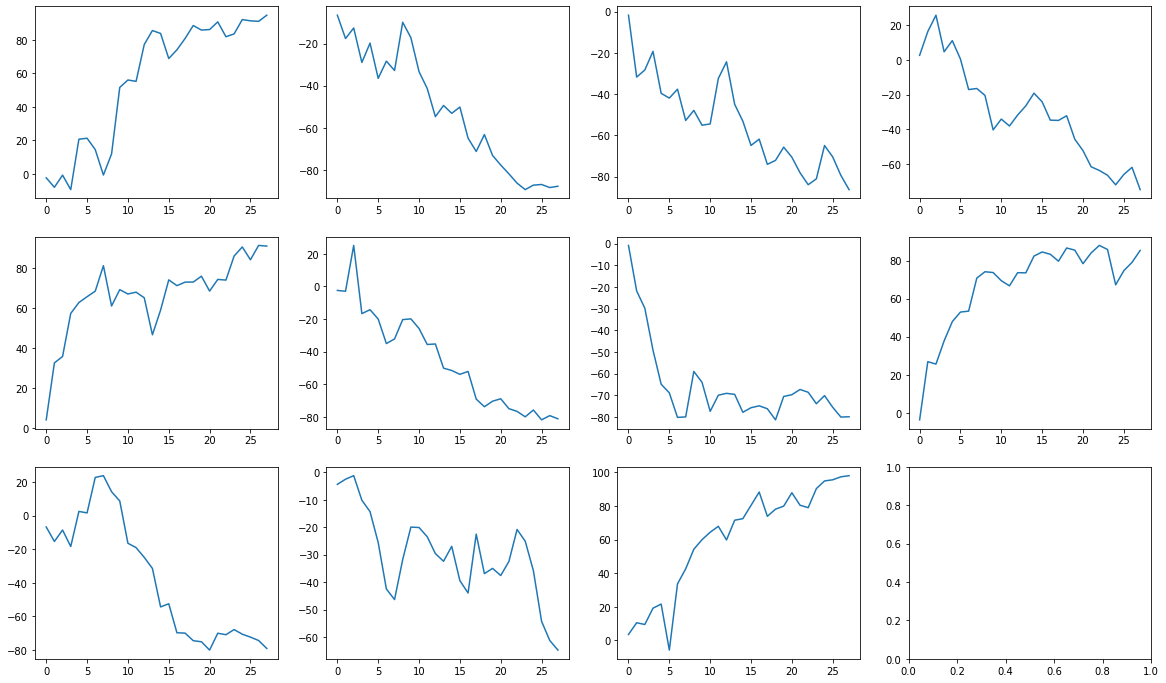

In [11]:
fig,a = plt.subplots(3,4,figsize=(20,12))
m = 0
n = 0
for i in np.arange(28,len(df['spy']),28):
    if(df.at[i,'cflow']/df.at[i,'spy'] < -5):
        delta = []
        for j in range(i-28,i):
            ## collect delta values corresponding to a single short position
            delta.append(df.at[j,'Delta'])
        #plt.figure(i)
        a[m][n].plot(delta)
        if(n<3):
            n+=1
        else:
            m+=1
            n=0

We can see that delta tends to a large positive or negative values when the loss is large. We can set a value and if delta crosses this value more than twice we will hedge our position with number of shares equal to largest integer less than delta. In other words perform delta hedging whenever delta crosse certain limit. Hedging should be done few days before the expiration date, otherwise the stock value would have already been depreciated/appreciated (since both are not good for short straddle).

In [12]:
#Cumulative shares purchased is the number of shares in the portfolio at a given time. 
df['cum_shares_purchased'] = 0
for i in np.arange(28,len(df['spy']),28):
    c = 0
    for j in range(i-28,i-8):
        if(abs(df.at[j,'Delta'])>40):
            c+=1
    if(c>=3):
        df.at[j,'cum_shares_purchased'] = int(df.at[j,'Delta'])

In [13]:
#Shares purchased is the number of shares purchased(long or short) on a particular day.
#This is equal to the difference in the current delta value and delta value when the shares were purchased last
c=0
df['Shares_purchased'] = 0
for i in range(len(df['spy'])):
    if(df.at[i,'cum_shares_purchased'] != 0):
        if(c==0):
            df.at[i,'Shares_purchased'] = df.at[i,'cum_shares_purchased']
            m = i
            c+=1
        else:
            df.at[i,'Shares_purchased'] = df.at[i,'cum_shares_purchased'] - df.at[m,'cum_shares_purchased']
            m = i

In [14]:
df['cum_shares_purchased'] = df['Shares_purchased'].cumsum()
#Hedging Cost is the cost of purchasing share
df['hedging_cost'] = df['spy'] * df['Shares_purchased']
#Cumulative Hedging Cost is the total hedging cost till date
df['cum_hedging_cost'] = df['hedging_cost'].cumsum() 
df['portfolio_value'] = df['cum_shares_purchased']*df['spy']
# Total profit is the cumulative profit from the short straddle and delta hedging
df['Profit'] = df['cum_cflow'] + df['portfolio_value'] - df['cum_hedging_cost']

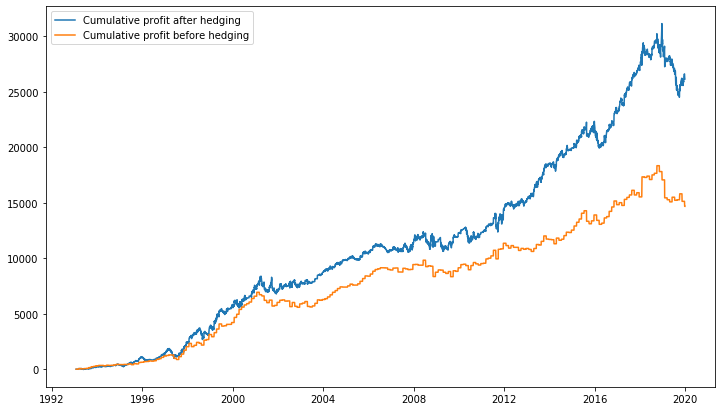

In [15]:
df.set_index('Date')
plt.figure(figsize=(12,7))
plt.plot_date(df['Date'],df['Profit'],'-',label='Cumulative profit after hedging')
plt.plot_date(df['Date'],df['cum_cflow'],'-',label='Cumulative profit before hedging')
plt.legend()